In [1]:
# March 31, 2023

In [2]:
%matplotlib notebook

In [3]:
import time

In [4]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
################################################
# from autograd.scipy.integrate import odeint
# from autograd.builtins import tuple
################################################

# from jax.experimental.ode import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [5]:
import jax 
import jax.numpy as jnp
from jax import jacfwd, jacrev

from jax import config
config.update('jax_enable_x64', True)

import numpy as np
# import autograd.numpy as np   # Thinly-wrapped version of Numpy
# from autograd import grad
# from autograd import jacobian

In [6]:
from scipy.integrate import quad

In [7]:
#General plotting functions
#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

## Parameter Estimation of Non-Linear ODE system

In [8]:
def RMS_error(y1,y2):
    term1 = np.sum((y1-y2)**2)
    return np.sqrt(term1)

In [9]:
def ODE_RHS_jax(t,lmbda,y):
    
    return jnp.array([-lmbda*y])

In [10]:
def exponential(t,lmbda,A):
    return A*np.exp(-lmbda*t)

In [11]:
'''

The parameters of the model are:
lmbda: the rate constant, which is to be estimated
A:     the value at t=0, which is to be estimated

'''

#Parameters of the model 
lmbda = np.log(2)/35.4   #to be estimated, in units of 1/hours
A = 2.0       #to be estimated, this is the value at t=0
num_unknown_parameters = 2 #Number of parameters to be estimated, will be used in ComputeWeights() function later

#Integration time
t_final = 48 #in hours
num_points_to_simulate = 20 #number of time points in total, of which 2 will be used to make estimates
GlobalSolverTime=np.linspace(0.0,t_final,num_points_to_simulate)
GlobalSolverTime_jax=jnp.linspace(0.0,t_final,num_points_to_simulate)


def ODE_RHS(t, lmbda,A,y):  #NumPy version of the system of ODEs
    #Note that the "A" argument is not being used. I put it here to show you can pass other params this way
    res = np.array([-lmbda*y]).flatten()
    return res


#True initial conditions 
InitialConditions=np.array([A])  
InitialConditions_jax=jnp.array([A])  

def ODEModel(y,t,*K):
    lmbda_temp,A_temp = K

    return ODE_RHS(t, lmbda_temp, A_temp, y)

Solution = odeint(ODEModel,InitialConditions,GlobalSolverTime,tuple([lmbda,A]))

In [12]:
Solution.shape

(20, 1)

<IPython.core.display.Javascript object>


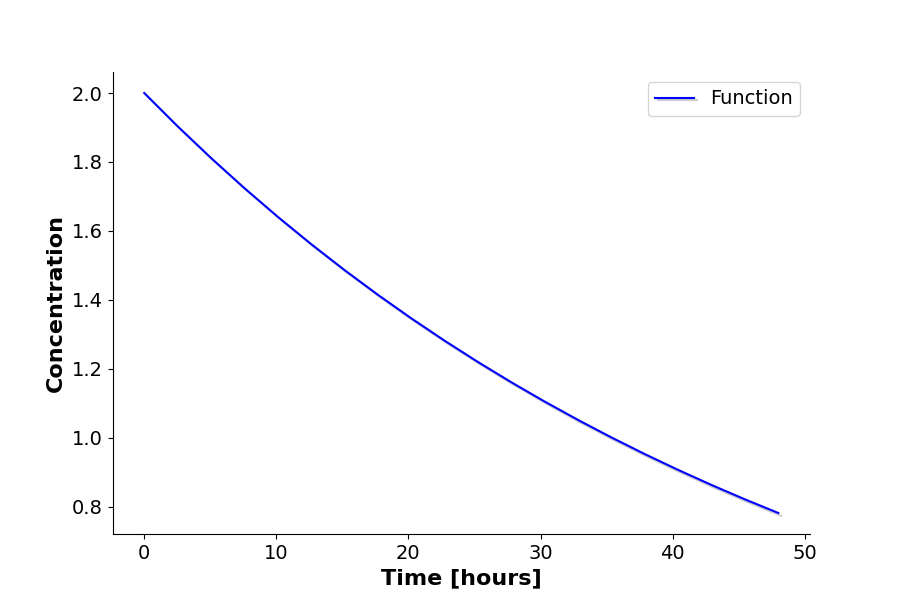

In [13]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(GlobalSolverTime,Solution[:,0],'b-',label='Function',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [hours]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')


In [14]:
PureSignal = Solution[:,0]

In [15]:
###############################################################################
#                            Noisy Data Generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    return [val+cal for val,cal in zip(Data,Noise)]

# np.random.seed(5)    
np.random.seed(10) #set random num. gen. SEED
sigma = 0.05
# GaussianNoise=[np.random.normal(0,0.10*val) for val in PureSignal]  #add in 5% Gaussian noise
GaussianNoise=[np.random.normal(0,sigma) for val in PureSignal]  #add in fixed 0.05 Gaussian noise
Signal_full=MakeNoisyData(PureSignal,GaussianNoise)                      #add Gaussian noise

Signal_full = jnp.asarray(Signal_full)                                        #measured data

<IPython.core.display.Javascript object>


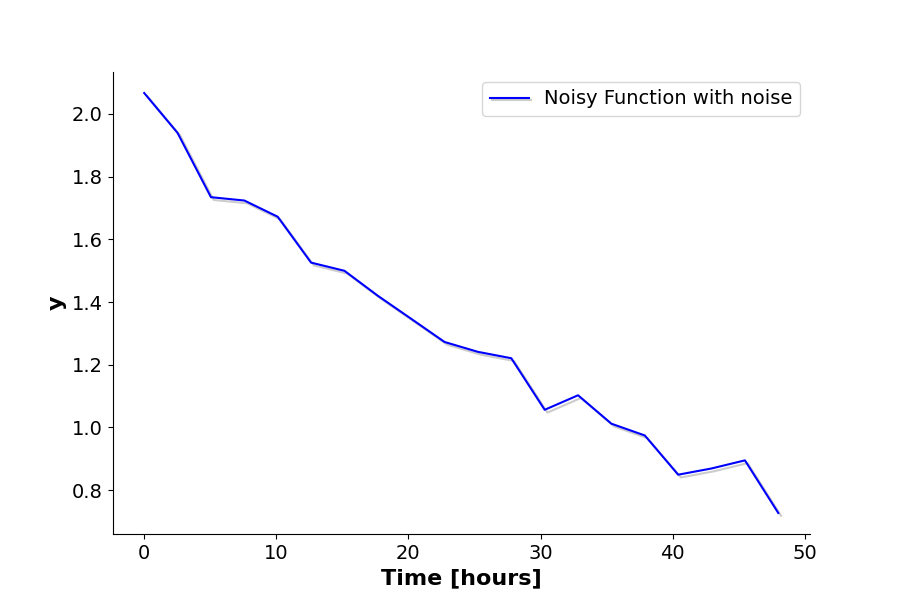

In [16]:
#Visualization
plt.figure(1,figsize=(9,6))

plt.plot(GlobalSolverTime,Signal_full,'b-',label='Noisy Function with noise',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [hours]',fontsize=16,fontweight='bold')
plt.ylabel('y',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')

In [18]:
num_signal_points = len(Signal_full)

In [19]:
###############################################################################
#                    ODE system model fitting  
###############################################################################
# LATER: Consider the initial parameters as two extra parameters (so 10+2 = 12 parameters in total)
#ModelSolver is the forward solver/integrator

def ModelSolver(t,lmbda_temp,A_temp):
     
    
    Solution=odeint(ODEModel,A_temp,t,tuple([lmbda_temp,A_temp]))
    return Solution[:,0].flatten()

def ModelFit(t,lmbda,A): 
    
    return ModelSolver(t,lmbda,A)

# p0 = np.random.rand(1)
p0 = np.array([-0.01,2]) #np.random.rand(2) #np.array([-1.6,2.9]) #initial guess
weights = np.ones(num_signal_points) #Initially, all weights are 1
sigma_now = 1/np.sqrt(weights)


ModelParams01=curve_fit(ModelFit,GlobalSolverTime,Signal_full,p0,sigma=sigma_now)

In [20]:
ModelParams01  #True value used is lmbda = np.log(2) / 35.4

(array([0.01965548, 2.01197738]),
 array([[2.96830738e-07, 9.65164339e-06],
        [9.65164339e-06, 5.25327660e-04]]))

In [21]:
np.log(2) / 35.4 #true value of lambda

0.019580428829376988

In [22]:
ModelParams01[0]

array([0.01965548, 2.01197738])

In [23]:
ModelParams01=curve_fit(exponential,GlobalSolverTime,Signal_full,p0,sigma=sigma_now)

In [24]:
fit = [exponential(t,ModelParams01[0][0],ModelParams01[0][1]) for t in GlobalSolverTime]

<IPython.core.display.Javascript object>


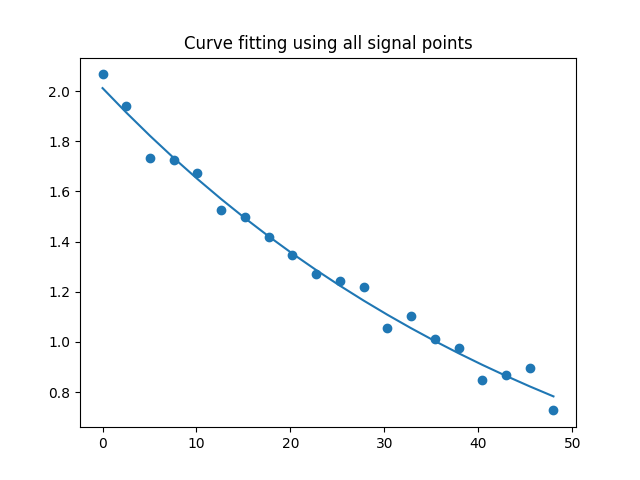

Text(0.5, 1.0, 'Curve fitting using all signal points')

In [25]:
plt.scatter(GlobalSolverTime, Signal_full,marker='o')
plt.plot(GlobalSolverTime,fit)
plt.title("Curve fitting using all signal points")

## Visualizing the cost landscape for estimating A and lambda

In [26]:
def exponential(t,lmbda,A):
    return A*np.exp(-lmbda*t)

In [27]:
sigma_array = np.ones(len(Signal_full)) * sigma
#Least squares loss (without factors in front)
def ls_loss(obs,lmbda,A):
    pred = exponential(GlobalSolverTime,lmbda,A)
    r = np.divide(pred-obs, sigma)
    return np.sum( r**2 )

# def compute_loss(x,y):
#     pred_points = exponential(GlobalSolverTime, x, y)
#     return ls_loss(pred_points,Signal,sigma_array)

#### Method 1 for visualizing the cost landscape

In [28]:
lmbda_arr = np.linspace(-1, 1, 500)
A_arr = np.linspace(0, 2.5, 500)

T, X, Y = np.meshgrid(GlobalSolverTime,lmbda_arr, A_arr)
Z = exponential(T, X, Y)

In [29]:
Z.shape

(500, 20, 500)

In [30]:
store_array1 = np.empty((500,20,500))
for index,item in enumerate(Z[1,:,1]):
#     print(index,item)
    store_array1[:,index,:] = np.divide((Z[:,index,:] - Signal_full[index]),sigma)**2

# store_array = np.empty((20,500,500))
# for i in range(len(lmbda_arr)):
#     for j in range(len(A_arr)):
#         store_array[i,j] = ls_loss(Signal,Z[:,i,j],Z[:,i,j])

In [31]:
Cost = np.sum(store_array1,axis=1)

In [32]:
Cost.shape

(500, 500)

In [33]:
# Redefine X and Y
X,Y = np.meshgrid(lmbda_arr, A_arr)

<IPython.core.display.Javascript object>


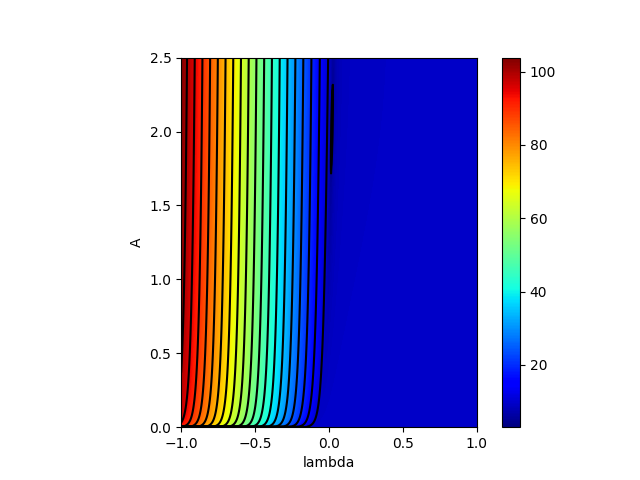

Text(0, 0.5, 'A')

In [34]:
contours = plt.contour(X, Y, np.log(Cost).T, 20, colors='black')
# plt.clabel(contours, inline=True, fontsize=8)

# plt.imshow(Cost, extent=[-2, 2, 0, 3], origin='lower',
#            cmap='magma', alpha=0.5)
# plt.colorbar();

plt.imshow(np.log(Cost.T), extent=[-1, 1, 0, 2.5], origin='lower',
           cmap='jet')
plt.colorbar()
plt.xlabel("lambda")
plt.ylabel("A")
# plt.scatter(np.argwhere(Cost==np.min(Cost))[0][0],np.argwhere(Cost==np.min(Cost))[0][1], marker='*')
# plt.axis(aspect='image');

In [35]:
np.argwhere(Cost==np.min(Cost))[0]

array([254, 391])

In [36]:
lmbda_arr[254] #best fit lambda

0.018036072144288484

In [37]:
A_arr[391] #best fit A

1.9589178356713426

#### Method 2 for visualization of the cost landscape (doing this as a check to see if Method 1 gave correct landscape)

In [41]:
lmbda_arr = np.linspace(-1, 1, 500)
A_arr = np.linspace(0, 2.5, 500)

In [42]:
store_array = np.empty((500,500))
for i in range(len(lmbda_arr)):
    for j in range(len(A_arr)):
        store_array[i,j] = ls_loss(Signal_full,lmbda_arr[i],A_arr[j])
        

In [43]:
store_array.shape

(500, 500)

In [44]:
# Redefine X and Y
X,Y = np.meshgrid(lmbda_arr, A_arr)

<IPython.core.display.Javascript object>


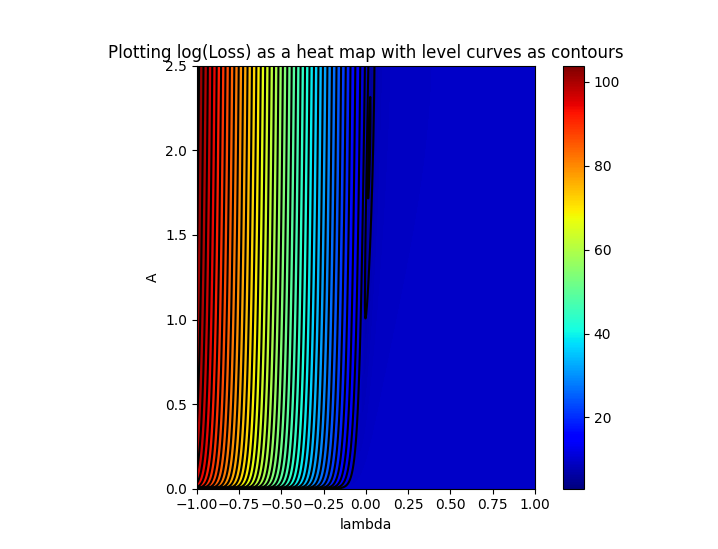

In [45]:
contours = plt.contour(X, Y, np.log(store_array.T), 40, colors='black')
# plt.clabel(contours, inline=True, fontsize=8)

# plt.imshow(Cost, extent=[-2, 2, 0, 3], origin='lower',
#            cmap='magma', alpha=0.5)
# plt.colorbar();

plt.imshow(np.log(store_array.T), extent=[-1, 1, 0, 2.5], origin='lower',
           cmap='jet')
plt.xlabel("lambda")
plt.ylabel("A")
plt.title("Plotting log(Loss) as a heat map with level curves as contours")
plt.colorbar()
# plt.axis(aspect='image');

In [49]:
np.argwhere(store_array==np.min(store_array))

array([[254, 391]])

In [50]:
lmbda_arr[254] #Best fit lambda

0.018036072144288484

In [51]:
A_arr[391] #Best fit A

1.9589178356713426

We can conclude that Method 1 and Method 2 both give the same cost landscape and so we can trust this.

## Fitting (replace lambda with log(2)/T_eff)

In [38]:
# Signal_full[np.array([2,3])]

In [39]:
num_points = 2 #the number of points we choose to do estimation with
chosen_point_indices = np.array([2,3])
Signal = Signal_full[chosen_point_indices]
Signal_times = GlobalSolverTime[chosen_point_indices]

In [40]:
# def exponential(t,lmbda,A):
#     return A*np.exp(-lmbda*t)

"""
T_eff is the effective half-life 

T_eff follows a log-normal distribution 
as proposed by: https://jnm.snmjournals.org/content/jnumed/62/7/1006.full.pdf

For Lu-177-PSMA-617, and the parotid gland in particular the paper gives T_eff:

mean = 35.4 hours
SD = 10.6 hours

The parameters mu_T and sigma_T of the log-normal distribution are computed below 
"""

mu_T = np.log( (35.4**2) / np.sqrt((35.4**2) + (10.6**2)) )
sigma_T = np.sqrt(np.log( 1 + ((10.6**2)/(35.4**2)) ) )
N = num_points #the number of points
np.random.seed(10) #set random num. gen. SEED , should match seed used for generating noise

def model_func(t, T_eff, A):
    return exponential(t, np.log(2)/T_eff, A)

def likelihood_onePoint(y_i, t_i, T_eff, A, sigma):
    term1 = 1.0/(sigma*np.sqrt(2*np.pi))
    res_squared = ( ( y_i - model_func(t_i, T_eff, A) ) / sigma ) **2
    term2 = np.exp(-0.5 * res_squared)
    #likelihood is term1 * term2, so log likelihood is log(term1) + log(term2)
    return  term1 * term2

def likelihood(T_eff, A, sigma, y_data = Signal, time_points = Signal_times):
    likelihood_array = likelihood_onePoint(y_data, time_points, T_eff, A, sigma)
    result = np.prod(likelihood_array) #multiply data points' likelihoods together
    return result

# def log_prior_T_eff(T_eff, sigma_T, mu_T):
#     """
#     This is the prior for the effective half-life T_eff. This prior is a log-normal distribution as
#     proposed by: https://jnm.snmjournals.org/content/jnumed/62/7/1006.full.pdf
    
#     Params:
    
#     T_eff: the candidate effective half-life
#     sigma_T: the standard deviation of the prior distribution for ln(T_eff)
#     mu_T   : the mean of the distribution for ln(T_eff)
    
#     """
#     term1 = 1.0 / ( T_eff * sigma_T * np.sqrt(2*np.pi) )
#     r2 =  ( (np.log(T_eff) - mu_T) / sigma_T ) **2 
#     term2 = np.exp(-0.5 * r2)
#     #prior is term1 * term2, so the log of this is log(term1) + log(term2)
#     return np.log(term1) + np.log(term2)

# def log_posterior_dist(T_eff, A, sigma, mu_T, sigma_T,  y_data = Signal, time_points = GlobalSolverTime):
#     log_posterior = log_prior_T_eff(T_eff, sigma_T, mu_T) + log_likelihood(T_eff, A, sigma, y_data, time_points)
#     return log_posterior

# def neg_log_posterior(parameter_array, mu_T, sigma_T,  y_data = Signal, time_points = GlobalSolverTime):
#     T_eff = parameter_array[0]
#     A = parameter_array[1]
#     result = -1 * log_posterior_dist(T_eff, A, sigma, mu_T, sigma_T,  y_data, time_points)
#     return result

def neg_log_posterior(parameter_array, mu_T, sigma_T,  y_data = Signal, time_points = Signal_times):
    T_eff = parameter_array[0]
    A = parameter_array[1]
    
    term1 = 1/(2*(sigma**2))
    residual_squared_array = np.sum ( (y_data-model_func(time_points, T_eff, A)) ** 2 )
    term2 = term1 * residual_squared_array
    
    term3 = np.log(T_eff * sigma_T * np.sqrt(2*np.pi))
    term4 = ((np.log(T_eff) - mu_T)**2)/(2 * (sigma_T**2))
    term5 = len(Signal) * np.log(sigma * np.sqrt(2*np.pi))
    
    neg_log_posterior = term3 + term4 + term5 + term2
    return neg_log_posterior

######################### Fisher Information Matrix functions #######################

#This is d^2(C)/dA^2 for one data point
def xi_OneSample(T_eff, sigma, t_i):
    term1 = 1/(sigma**2)
    exponent = (-2 * np.log(2) * t_i) / T_eff
    term2 = np.exp(exponent)   
    return term1 * term2


#This is d^2(C)/dTdA for one data point
def h_OneSample(A, T_eff, t_i, y_i):
    #sigma is defined globally
    term1 = 1/(sigma**2)
    exponent = (-2 * np.log(2) * t_i) / T_eff
    term2 = A * np.exp(exponent) * (2*np.log(2)*t_i / (T_eff**2))
    term3 = y_i * t_i * (np.log(2) / (T_eff**2)) * np.exp(exponent/2.0)
    result = term1 * (term2 - term3)    
    return result

#The following function involves integrating over y_i, so is not a function of y_i (but is one of t_i)
def EXPECTED_h_OneSample(A, T_eff, t_i):
    #"sigma" is defined globally
    def integrand(y_i, t_i, T_eff, A, sigma=sigma):
        return likelihood_onePoint(y_i, t_i, T_eff, A, sigma) * h_OneSample(A, T_eff, t_i, y_i)
    Expected_h_for_point = (quad(integrand, -np.inf, np.inf, args=(t_i,T_eff,A)))[0]
    return Expected_h_for_point

######################################################################
def I_TA(A, T_eff, time_points = Signal_times):
    num_points = len(time_points.flatten())
    arr = np.zeros(num_points)
    for i in range(num_points):
        arr[i] = EXPECTED_h_OneSample(A, T_eff, time_points[i])
    return np.sum(arr)
######################################################################

#This is d^2(C)/dT^2 for one data point MINUS g(T) which will be added later
def f_OneSample(A, T_eff, t_i, y_i):
    term1 = 1/(sigma**2)
    exponent = (-2 * np.log(2) * t_i) / T_eff
    term2 = (2*(A**2)*(np.log(2) * t_i) * np.exp(exponent) * (np.log(2)*t_i - T_eff)) / (T_eff**4)
    term3 = (A * y_i * (2 * np.log(2) * t_i) * np.exp(exponent/2.0) * (np.log(2) - (2*T_eff))) / (T_eff*4)
    result = term1 * (term2 - term3)
    return result

#The following function involves integrating over y_i, so is not a function of y_i (but is one of t_i)
def EXPECTED_f_OneSample_plus_PriorTerm(A, T_eff, t_i):
    #"sigma" is defined globally
    def integrand(y_i, t_i, T_eff, A, sigma=sigma):
        return likelihood_onePoint(y_i, t_i, T_eff, A, sigma) * f_OneSample(A, T_eff, t_i, y_i)
    
    Expected_f_for_point = (quad(integrand, -np.inf, np.inf, args=(t_i,T_eff,A)))[0]
    return Expected_f_for_point + (g(T_eff)/N)

#This is the term added by the prior to d^2(C)/dT^2, needs to be added to (1/sigma^2) * sum(f_i) to get d^2(C)/dT^2
def g(T_eff):
    term1 = -1.0/(T_eff**2)
    term2 = (mu_T + 1 - np.log(T_eff)) / ((T_eff**2) * (sigma_T**2))
    return term1 + term2
#######################################################################
def I_TT(A, T_eff, time_points = Signal_times):
    num_points = len(time_points.flatten())
    arr = np.zeros(num_points)
    for i in range(num_points):
        arr[i] = EXPECTED_f_OneSample_plus_PriorTerm(A, T_eff, time_points[i])
    return np.sum(arr) 
#######################################################################
#This does not involve integrating over y_i because it is not a function of y_i
def I_AA(T_eff, sigma=sigma, time_points=Signal_times):
    num_points = len(time_points.flatten())
    arr = np.zeros(num_points)
    for i in range(num_points):
        arr[i] = xi_OneSample(T_eff, sigma, time_points[i])
    return (1/(sigma**2)) * np.sum(arr)
######################################################################
# "time_points" could contain just one data point
def compute_FIM(A, T_eff,time_points):
    FIM_array = np.empty((2,2))
    
    FIM_array[0,0] = I_AA(T_eff, sigma, time_points)
    FIM_array[0,1] = I_TA(A, T_eff, time_points)
    FIM_array[1,0] = FIM_array[0,1]
    FIM_array[1,1] = I_TT(A, T_eff, time_points)
    
    return FIM_array

In [41]:
##################### Test to see if the likelihood function is working as expected ##########################

In [42]:
likelihood_onePoint(1, 1, 1, 2, 1) 

0.3989422804014327

In [43]:
likelihood_onePoint(2, 3, 1, 2, 1)

0.08627731882651153

The two likelihoods above, when multiplied together should give the same as the output of the code below.
If they indeed do, then the likelihood function defined above works as expected

In [44]:
ytest = np.array([1,2])
t_test = np.array([1,3])
res = likelihood_onePoint(ytest, t_test, 1, 2, 1)
print(res[0] * res[1])

0.034419670319569974


In [45]:
likelihood_onePoint(1, 1, 1, 2, 1) * likelihood_onePoint(2, 3, 1, 2, 1)

0.034419670319569974

In [46]:
#Using the likelihood function defined above should give the same:
likelihood(1,2,1,ytest,t_test)

0.034419670319569974

It looks like our likelihood function passed this test. 

In [47]:
##################################### Fitting #################################################

In [48]:
sigma_T

0.2930306249807689

In [49]:
# neg_log_posterior(np.array([1.0,5.0]), mu_T, sigma_T, Signal,Signal_times)

In [50]:
p0 = np.random.rand(2) #this will give the same set of initial guesses each run since we set the seed previously.
# p0 = np.array([])
Optim_results = minimize(neg_log_posterior, p0, args=(mu_T, sigma_T, Signal, Signal_times), method='Nelder-Mead',
        bounds = [(0.00001,np.inf),(-np.inf,np.inf)])

In [51]:
Optim_results

 final_simplex: (array([[34.86296142,  1.95868238],
       [34.86289903,  1.95868263],
       [34.86289779,  1.95868325]]), array([-0.32526626, -0.32526626, -0.32526626]))
           fun: -0.3252662592400454
       message: 'Optimization terminated successfully.'
          nfev: 189
           nit: 99
        status: 0
       success: True
             x: array([34.86296142,  1.95868238])

In [52]:
T_eff_estimate = Optim_results.x[0]
A_estimate = Optim_results.x[1]

In [53]:
#True T_eff = 35.4 hours
#True A = 2.0

In [54]:
Fit = [model_func(t,T_eff_estimate, A_estimate) for t in GlobalSolverTime]

<IPython.core.display.Javascript object>


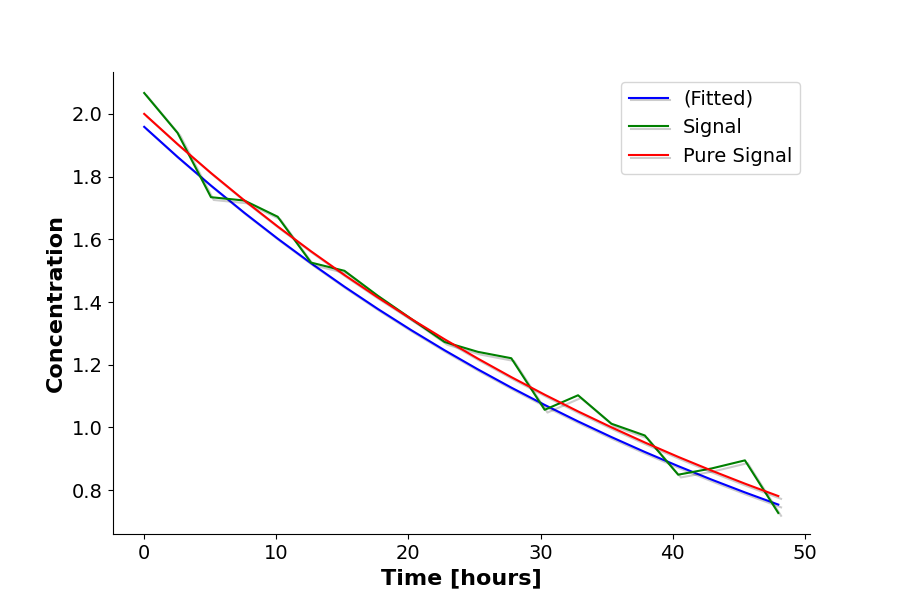

In [55]:
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(GlobalSolverTime,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(GlobalSolverTime,Signal_full,'g-',label='Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(GlobalSolverTime,PureSignal,'r-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [hours]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')


In [44]:
# I_for_chosen_points = compute_FIM(A_estimate, T_eff_estimate,Signal_times)

In [45]:
# np.asarray(Signal_times[0])

In [46]:
# compute_FIM(A_estimate, T_eff_estimate,np.asarray([Signal_times[0]]))

In [47]:
# np.linalg.det(compute_FIM(A_estimate, T_eff_estimate,np.asarray([Signal_times[0]])))

In [48]:
# np.empty((N,)).shape

In [56]:
weights = np.empty((num_points_to_simulate,))
for index,item in enumerate(GlobalSolverTime):
    weights[index] = np.linalg.det(compute_FIM(A_estimate, T_eff_estimate,np.asarray([item])))

In [57]:
weights

array([6.79528219e+02, 3.48183114e+08, 5.69616858e+08, 6.98907108e+08,
       7.62260853e+08, 7.79397620e+08, 7.65042882e+08, 7.30092746e+08,
       6.82520106e+08, 6.28077802e+08, 5.70842645e+08, 5.13634955e+08,
       4.58340898e+08, 4.06159108e+08, 3.57788487e+08, 3.13570405e+08,
       2.73595704e+08, 2.37784585e+08, 2.05945718e+08, 1.77819485e+08])

In [51]:
# idx = (-weights).argsort()[:2] #indices of time points with two highest weights

In [52]:
# idx

In [53]:
# GlobalSolverTime

In [54]:
################################## Find top two points #############################

In [58]:
from itertools import combinations
from scipy.special import comb

In [59]:
def rSubset(arr, r):
  
    # return list of all subsets of length r
    # to deal with duplicate subsets use 
    # set(list(combinations(arr, r)))
    return set(list(combinations(arr, r)))

# Driver Function
if __name__ == "__main__":
    arr = np.arange(len(GlobalSolverTime)) #indices of all time points to simulate
    r = 2
    all_combinations = (rSubset(arr, r))

# Turn the "all_combinations" Python set object into a NumPy array:
all_combinations = np.array(list(all_combinations))

In [60]:
################ TEST for rSubset function #################

In [61]:
len((rSubset(arr, r))) 

190

In [62]:
comb(len(GlobalSolverTime),2) #this should equal the above

190.0

In [63]:
# chosen_point_indices = np.array([2,3])
# Signal = Signal_full[chosen_point_indices]
# Signal_times = GlobalSolverTime[chosen_point_indices]

In [64]:
all_combinations.shape

(190, 2)

In [65]:
estimates = np.empty(all_combinations.shape)
top_two_indices_array = np.empty(all_combinations.shape)

In [66]:
for index1, item1 in enumerate(all_combinations):
    np.random.seed(index1)
    chosen_point_indices = item1
    Signal = Signal_full[chosen_point_indices]
    Signal_times = GlobalSolverTime[chosen_point_indices]
    
    p0 = np.random.rand(2) #this will give the same set of initial guesses each run since we set the seed previously.
    Optim_results = minimize(neg_log_posterior, p0, args=(mu_T, sigma_T, Signal, Signal_times), method='Nelder-Mead',
        bounds = [(0.00001,np.inf),(-np.inf,np.inf)])
    
    estimates[index1] = Optim_results.x
    print(estimates[index1])
    
    weights = np.empty((num_points_to_simulate,))
    for index2,item2 in enumerate(GlobalSolverTime):
        weights[index2] = np.linalg.det(compute_FIM(estimates[index1][1], estimates[index1][0],np.asarray([item2])))
    
    idx = (-weights).argsort()[:2] #indices of time points with two highest weights
    
    top_two_indices_array[index1] = idx

[39.1145755   1.97252832]
[34.83631574  2.02547071]
[31.81535565  2.08554251]
[37.95750535  1.98793399]
[37.66965792  1.94457019]
[31.11264159  2.11225116]
[29.24430492  2.06364757]
[32.87212424  1.99323738]
[39.9272372   1.92983512]
[35.15191161  2.00351068]
[34.12271264  2.06838271]
[42.04635324  1.89951769]
[29.8336791   2.31746404]
[35.27400509  2.04077667]
[30.33544234  2.32934587]
[37.65230344  2.0031569 ]
[34.06223806  2.05221906]
[31.37013292  2.09935473]
[28.10792732  2.57326879]
[34.23607366  2.02179237]
[42.56893087  1.78620013]
[36.17850831  1.99818848]
[32.8453704   1.99543513]
[37.01965526  2.0038568 ]
[31.63929728  2.21484988]
[32.46376344  2.09668382]
[32.46525048  2.06815666]
[39.26222401  1.94281031]
[31.26772175  2.10706869]
[31.49496004  2.06676743]
[26.30715594  2.51364229]
[33.22379856  2.04699021]
[34.65539964  2.04184313]
[27.0660304   2.53494672]
[37.35593479  2.00095639]
[29.13152014  2.31721079]
[30.07870947  2.13089013]
[34.15556547  2.01747643]
[35.35358582

In [67]:
estimates.shape

(190, 2)

In [68]:
top_two_indices_array.shape

(190, 2)

In [69]:
top_two_indices_array

array([[6., 5.],
       [5., 6.],
       [5., 4.],
       [5., 6.],
       [5., 6.],
       [4., 5.],
       [4., 5.],
       [5., 4.],
       [6., 5.],
       [5., 6.],
       [5., 4.],
       [6., 7.],
       [4., 5.],
       [5., 6.],
       [4., 5.],
       [5., 6.],
       [5., 4.],
       [4., 5.],
       [4., 5.],
       [5., 4.],
       [6., 7.],
       [5., 6.],
       [5., 4.],
       [5., 6.],
       [5., 4.],
       [5., 4.],
       [5., 4.],
       [6., 5.],
       [4., 5.],
       [5., 4.],
       [4., 3.],
       [5., 4.],
       [5., 6.],
       [4., 3.],
       [5., 6.],
       [4., 5.],
       [4., 5.],
       [5., 4.],
       [5., 6.],
       [5., 6.],
       [5., 4.],
       [4., 5.],
       [5., 4.],
       [5., 6.],
       [5., 4.],
       [5., 6.],
       [5., 4.],
       [5., 6.],
       [3., 4.],
       [5., 6.],
       [5., 6.],
       [3., 4.],
       [5., 4.],
       [5., 6.],
       [5., 4.],
       [5., 6.],
       [4., 5.],
       [4., 5.],
       [5., 4.

In [70]:
flattened_top_two_idx_array = top_two_indices_array.flatten().astype(int)

In [71]:
flattened_top_two_idx_array

array([6, 5, 5, 6, 5, 4, 5, 6, 5, 6, 4, 5, 4, 5, 5, 4, 6, 5, 5, 6, 5, 4,
       6, 7, 4, 5, 5, 6, 4, 5, 5, 6, 5, 4, 4, 5, 4, 5, 5, 4, 6, 7, 5, 6,
       5, 4, 5, 6, 5, 4, 5, 4, 5, 4, 6, 5, 4, 5, 5, 4, 4, 3, 5, 4, 5, 6,
       4, 3, 5, 6, 4, 5, 4, 5, 5, 4, 5, 6, 5, 6, 5, 4, 4, 5, 5, 4, 5, 6,
       5, 4, 5, 6, 5, 4, 5, 6, 3, 4, 5, 6, 5, 6, 3, 4, 5, 4, 5, 6, 5, 4,
       5, 6, 4, 5, 4, 5, 5, 4, 5, 4, 4, 5, 5, 4, 4, 5, 5, 6, 5, 4, 5, 6,
       5, 6, 6, 5, 4, 5, 4, 5, 5, 4, 5, 6, 4, 3, 6, 5, 4, 5, 4, 5, 5, 6,
       5, 6, 6, 5, 5, 6, 5, 6, 5, 4, 6, 5, 4, 5, 5, 4, 5, 6, 6, 5, 5, 6,
       5, 6, 5, 6, 5, 6, 5, 4, 5, 4, 5, 4, 5, 4, 6, 5, 5, 6, 4, 5, 5, 4,
       5, 6, 4, 5, 5, 4, 5, 6, 6, 5, 5, 6, 5, 6, 5, 4, 5, 6, 5, 4, 5, 4,
       5, 4, 6, 5, 5, 6, 5, 4, 4, 3, 5, 4, 5, 6, 5, 4, 5, 6, 5, 6, 6, 5,
       5, 4, 5, 4, 5, 4, 5, 4, 6, 5, 5, 6, 6, 5, 5, 4, 5, 4, 5, 4, 5, 4,
       5, 4, 5, 6, 4, 5, 4, 5, 5, 6, 5, 6, 5, 6, 6, 5, 4, 5, 4, 5, 5, 4,
       5, 4, 4, 5, 4, 5, 5, 4, 5, 4, 5, 6, 5, 6, 6,

In [72]:
#find frequency of each value
my_array = flattened_top_two_idx_array
values, counts = np.unique(my_array, return_counts=True)

#display all values with highest frequencies
values[counts == counts.max()]

array([5])

In [73]:
counts

array([  6, 108, 182,  82,   2])

In [74]:
values

array([3, 4, 5, 6, 7])

In [75]:
# So time points with indices 4 and 5 have the highest importances

In [76]:
estimates

array([[39.1145755 ,  1.97252832],
       [34.83631574,  2.02547071],
       [31.81535565,  2.08554251],
       [37.95750535,  1.98793399],
       [37.66965792,  1.94457019],
       [31.11264159,  2.11225116],
       [29.24430492,  2.06364757],
       [32.87212424,  1.99323738],
       [39.9272372 ,  1.92983512],
       [35.15191161,  2.00351068],
       [34.12271264,  2.06838271],
       [42.04635324,  1.89951769],
       [29.8336791 ,  2.31746404],
       [35.27400509,  2.04077667],
       [30.33544234,  2.32934587],
       [37.65230344,  2.0031569 ],
       [34.06223806,  2.05221906],
       [31.37013292,  2.09935473],
       [28.10792732,  2.57326879],
       [34.23607366,  2.02179237],
       [42.56893087,  1.78620013],
       [36.17850831,  1.99818848],
       [32.8453704 ,  1.99543513],
       [37.01965526,  2.0038568 ],
       [31.63929728,  2.21484988],
       [32.46376344,  2.09668382],
       [32.46525048,  2.06815666],
       [39.26222401,  1.94281031],
       [31.26772175,

In [79]:
# Let's pick estimates where time point with index 5 (most important) and time point index 4 (second imp.) were used
T_eff_estimate = estimates[2][0]
A_estimate = estimates[2][1]

In [80]:
T_eff_estimate

31.81535564810819

In [81]:
A_estimate

2.0855425136218417

In [83]:
# model_func(0,T_eff_estimate, A_estimate)

In [84]:
Fit = [model_func(t,T_eff_estimate, A_estimate) for t in GlobalSolverTime]

In [92]:
sigma_array

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

<IPython.core.display.Javascript object>


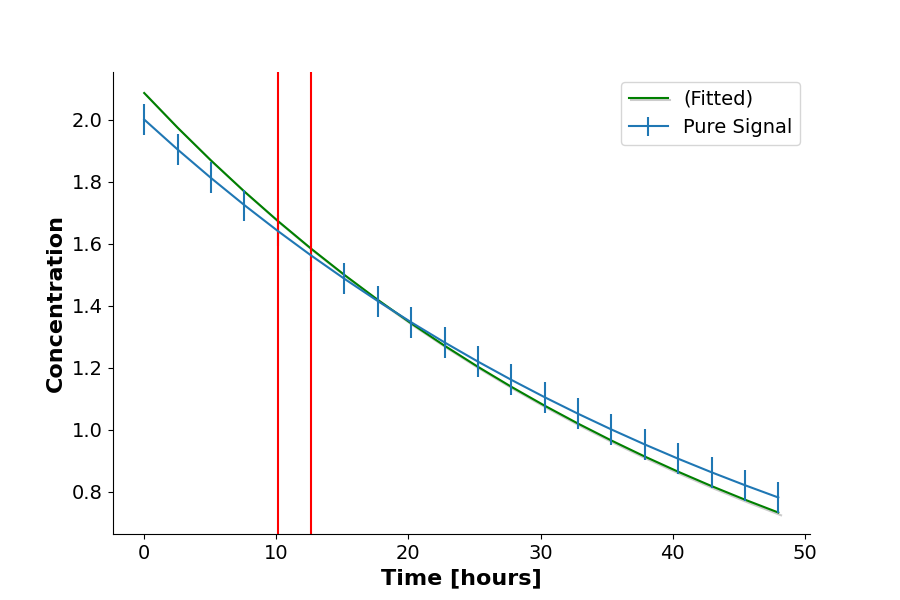

In [98]:
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(GlobalSolverTime,Fit,'g-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.errorbar(GlobalSolverTime,PureSignal,yerr=sigma_array,label='Pure Signal')
# plt.plot(GlobalSolverTime,Signal_full,'r-',label='Noisy Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                        path_effects.Normal()])

plt.xlabel('Time [hours]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

plt.axvline(x=GlobalSolverTime[5],color='r',label="most important")
plt.axvline(x=GlobalSolverTime[4],color='r',label="second most important")

ax=plt.gca()
PlotStyle(ax,'')


In [ ]:
############################### IGNORE EVERYTHING BELOW THIS LINE ##############################

In [ ]:
rms_error = RMS_error(Fit,PureSignal) #RMS error 
rms_error 

In [ ]:
from jax.experimental.ode import odeint as odeint_jax

In [ ]:
#ModelSolver is the forward solver/integrator

def ModelSolver_g(K):
    lmbda_temp = K
    
    def LocalModel(y,t):
        return ODE_RHS_jax(t, lmbda_temp, y)
    
    Solution=odeint_jax(LocalModel,InitialConditions_jax,GlobalSolverTime_jax)
    
    return Solution[:,0].flatten()

In [ ]:
# jacobian_func = jacobian(ModelSolver_g,(0)) #Define the jacobian outputting function, AUTOGRAD function
jacobian_fn = jacrev(ModelSolver_g) 

In [ ]:
# jacobian_output = jacobian_func(np.array([1.0,0.5,0.5,0.005,0.05,1.6,0.04,4.0,5.0,0.1]))
jacobian_output = jacobian_fn(jnp.array([1.0]))

In [ ]:
# jacobian_output = np.asarray(jacobian_output)

In [ ]:
# type(jacobian_output)

In [ ]:
# jacobian_output.shape  #[num_data_points,num_parameters]

In [ ]:
#concatenated data is assumed to have Gaussian noise added
#p0: parameter guesses in first iteration, will change
def ParameterEstimation(current_weights_temp,S2_concatdata,S2_SolverTime, previous_estimates = p0):
    # p0 = np.random.rand(4)
#     weights = np.ones(S2_concatdata) #Initially, all weights are 1
    zero_idx = np.argwhere(current_weights_temp < 1e-25)
    current_weights_temp[zero_idx] = 1e-25
#     current_weights = current_weights/np.sum(current_weights) #do this normalization outside of this function
    current_sigma = 1/np.sqrt(current_weights_temp)
#     print(current_sigma.shape)
#     print(S2_concatdata.shape)
    OptimPar_and_covMatrix=curve_fit(ModelFit,S2_SolverTime,S2_concatdata,previous_estimates,sigma=current_sigma)
    return OptimPar_and_covMatrix #a tuple, parameters estimated from S2 data points

In [ ]:
#input index of  data point that we want the weight of
def ComputeWeights(iw):
    # "i" is the index of data points S1
    #JTJ = np.matmul(J.T,J)
    #I = JTJ #approximate total Fisher Information Matrix at optimal parameters. 
    
    #for i in range(data_points):
    i = int(iw[0])
    current_weights = iw[1:]

    S2_data_signal = np.delete(Signal,i)
    S2_SolverTime = np.delete(GlobalSolverTime,i)
    S2_weights = np.delete(current_weights, i)

    ParamEstimates_andCovMatrix = ParameterEstimation(S2_weights,S2_data_signal,S2_SolverTime) 
    
#     print(f'{ParamEstimates_andCovMatrix}')
    
    #Now to compute the Jacobian using the parameters estimated from S2
    
    unknown_parameter_estimates = np.asarray(ParamEstimates_andCovMatrix[0])
#     temp_parameter_array = np.asarray(true_parameter_array)
#     temp_parameter_array[est_par_index] = unknown_parameter_estimates
    
    #this computes Jacobian of ALL points with respect to ALL parameters
    
    jacobian_output = jacobian_fn(unknown_parameter_estimates) 
    jacobian_output = np.asarray(jacobian_output)
#     J = jacobian_output[:,est_par_index]  #this is our J, est_par_index is defined globally
    J = jacobian_output #this is our J, est_par_index is defined globally
#     print(f'{unknown_parameter_estimates}')
#     print(f'{jacobian_output}')

#     print(f'{J}')
    
    #Now to form J^T * W * J
    W = np.diag(current_weights)
    ##############################################################################
#     WJ = np.matmul(W,J) #the "WJ" part in J^T * W * J
#     #this is our J_T*W*J which is the Fisher information matrix approximation
#     #This is also I, the total Fisher Information Matrix approximation, using the estimated pars from S2
#     JTWJ = np.matmul(J.T,WJ)   #I
#     ###############################################################################
    
    #First form I_S1
    S1_row_in_jacobian = J[i,:].reshape(1,num_unknown_parameters) #num_unknown_parameters defined globally
    #W should be diagonal, JTWJ_S1 should have shape [num_unknown_parameters,num_unknown_parameters]
    JTWJ_S1 = W[i,i] * np.matmul(S1_row_in_jacobian.T,S1_row_in_jacobian) 
    I_S1 = JTWJ_S1  
    
    #Now form I_S2
    time_point_indices = np.arange(len(Signal))
    S2_indices = (np.setdiff1d(time_point_indices,i)).astype(int)
#     print(type(S2_indices))
    #If num of S2 points was 1, you'd need to reshape this. But it probably isn't 1, UNLESS you have two time data points
    S2_rows_in_jacobian = J[S2_indices,:] 
    W_forS2 = np.diag(current_weights[S2_indices])
#     print(f'{J}')
    print(f"#########  i = {i} #########")
    print(f'{W_forS2}')
    print("######################")
#     print(f'{S2_rows_in_jacobian}')
    
    try:
        WJ_S2 = np.matmul(W_forS2,S2_rows_in_jacobian)
        I_S2 = np.matmul(S2_rows_in_jacobian.T,WJ_S2)
    except:
        print(f'{WJ_S2}')
        print(f'{J}')
        print(f'{S2_rows_in_jacobian}')
    
    
    
        
    
    
#     I_S1_I_S2 = np.matmul(I_S1,I_S2)
    
#     identity_matrix = np.identity(I_S1_I_S2.shape[0])
#     I_S1_I_S2_inv = np.linalg.solve(I_S1_I_S2,identity_matrix)
    identity_matrix = np.identity(I_S2.shape[0])
    try:
        I_S2_inv = np.linalg.solve(I_S2,identity_matrix)
    except:
        print(" ")
        print(f'{i}')
        print(f'{I_S2}')
        print(f'{S2_indices}')
    
#     uncertainty_of_S1_given_S2 = (1.0/num_unknown_parameters) * np.trace(I_S1_I_S2_inv)
    uncertainty_of_S1_given_S2 = (1.0/num_unknown_parameters) * np.trace(np.matmul(I_S1,I_S2_inv))
    
    new_S1_weight = uncertainty_of_S1_given_S2
    
    return new_S1_weight

In [ ]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

i_array.shape

arr = np.hstack((i_array,initial_weights))

arr.shape

In [ ]:
p0

In [ ]:
p0.size

In [ ]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [ ]:
p0 

In [ ]:
np.save("NoisyData_Seed20_FixedZeroPointOneNoise_10Points_Gaussian.npy",Signal)

In [ ]:
arr

In [ ]:
# np.set_printoptions(precision=40)
# arr_iteration 

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
arr_iteration

In [ ]:
weights_array[7,:]

In [ ]:
result1

In [ ]:
#7263.5/60 #121.1 mins for 20 iterations, floor = 1e-20, random seed=10, fixed 0.2 gaussian noise

In [ ]:
7232/60

In [ ]:
7180.7/60

In [ ]:
weights_array[29:30,18:20]

In [ ]:
#7236/60 = 120.6 mins taken for 20 iterations, 10% Gaussian noise, random seed = 5

In [ ]:
#7120.273985147476/60  =119 mins taken for 20 iterations, random seed = 5

In [ ]:
# 7157.896894931793/60 #119.3 mins for 20 iterations

In [ ]:
# 704.9233162403107/60 #took 12 mins

In [ ]:
np.argwhere(weights_array<0)

In [ ]:
weights_array.shape

In [ ]:
weights_array

In [ ]:
plt.plot(GlobalSolverTime, np.log(weights_array[20,:]))

In [ ]:
np.argwhere(weights_array[20,:]==np.max(weights_array[20,:]))

In [ ]:
weights_array[20,19]

In [ ]:
# np.argwhere(weights_array[20,:]==np.min(weights_array[20,:]))

In [ ]:
weights_array[20,56]

In [ ]:
plt.plot(GlobalSolverTime, (weights_array[20,:]))

In [ ]:
plt.plot(np.arange(21),np.log(weights_array[:,190]))

In [ ]:
plt.scatter(np.arange(21),np.log(weights_array[:,19]))

In [ ]:
estimated_parameters_array

In [ ]:
def nsmall(a, n):
    return np.partition(a, n)[n]

In [ ]:
nsmall(weights_array[-1,:],199)

In [ ]:
np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],199))

In [ ]:
20*20/200

In [ ]:
np.min(weights_array[20,:])

In [ ]:
fitSolverTime = GlobalSolverTime

#Visualize fit solution
lmbda_fit = estimated_parameters_array[-1]

Fit = ModelSolver(fitSolverTime,lmbda_fit, InitialConditions)
# prb_fit = Fit[:(int(len(Fit)/2))]
# e2f1_fit= Fit[int((len(Fit)/2)):]

#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(fitSolverTime,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(fitSolverTime,Signal,'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==np.max(weights_array[20,:]))],color='r',label="most weight")
plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],num_points-2))],color='b',label="2nd most weight")
# plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==np.min(weights_array[20,:]))], color='y',label="least weight")
# plt.axvline(x=fitSolverTime[np.argwhere(weights_array[-1,:]==nsmall(weights_array[-1,:],1))],color='m',label="2nd least weight")

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')


In [ ]:
weights_array

In [ ]:
rms_error = RMS_error(Fit,PureSignal) #RMS error 
rms_error 

In [ ]:
np.argwhere(abs(Signal - PureSignal) == np.max(abs(Signal - PureSignal)))

In [ ]:
def exp_func(lmbda_temp,t=GlobalSolverTime):
    return np.exp(lmbda_temp*t)

In [ ]:
np.argmax(PureSignal-Signal)

In [ ]:
# plt.plot(exp_funcv(1.4,GlobalSolverTime))

In [ ]:
exp_func(-0.5).shape

In [ ]:
# plt.plot(GlobalSolverTime,np.apply_along_axis(exp_func,0, GlobalSolverTime,np.ones(200)))

In [ ]:
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((Signal-temp)**2)  
# Loss_v = np.vectorize(Loss)

In [ ]:
Loss(-0.5)

In [ ]:
num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((Signal-temp)**2)) 
    

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array))

In [ ]:
lambda_array[np.argwhere(loss_store_array == np.min(loss_store_array))]

In [ ]:
%matplotlib notebook

In [ ]:
plt.plot(lambda_array,np.log(loss_store_array))

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #index of min lambda

In [ ]:
lambda_array[326] #minimum lambda

In [ ]:
# plt.plot(np.linspace(-0.6,0.6,200),np.log(loss),s=0.8)

In [ ]:
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(new_weights,(Signal-temp)**2))) 
    

In [ ]:
plt.plot(np.arange(200),new_weights[-1,:])

In [ ]:
plt.plot(lambda_array,weighted_loss_store_array)

In [ ]:
# plt.plot(fitSolverTime[:5],Fit[:5],'b-',label='(Fitted) P_b+P_int+P_intern',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                        path_effects.Normal()])
# plt.plot(fitSolverTime[:5],PureSignal[:5],'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
#                        path_effects.Normal()])

In [ ]:
# estimated_parameters_array

In [ ]:
ld_weights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
plt.plot(GlobalSolverTime,ld_weights[5,:])

# Plots

Define some functions

In [ ]:
# def exp_func(lmbda_temp,t=GlobalSolverTime):
#     return np.exp(lmbda_temp*t)
# def Loss(lmbda_temp):
#     temp = A*exp_func(lmbda_temp)
#     return np.sum((Signal-temp)**2)  

# num_lambda_points = 1000
# lambda_array = np.linspace(-0.75,0,num_lambda_points)
# loss_store_array = np.zeros(num_lambda_points)
# for index,item in enumerate(lambda_array):
#     temp = A*exp_func(item)
#     loss_store_array[index] = (np.sum((Signal-temp)**2)) 

In [ ]:
def RMS_error(y1,y2):
    term1 = np.sum((y1-y2)**2)
    return np.sqrt(term1)

### 5% gaussian noise

In [ ]:
#20 Iterations
#Random seed
#5% gaussian noise
#200 points between t=0 and t=20
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved (mistake: future runs saved the noisy data as well), hence could not plot the loss
function.
"""

weights1 = np.load("FirstRun_SimpleExpModel_weights_20_iterations.npy")
params1 = np.load("FirstRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations.npy")

In [ ]:
Plot_Time = np.linspace(0,20,200)
Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,Solution,'g-',label='Pure Signal',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
Fit.shape

In [ ]:
Solution.shape

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')

In [ ]:
rms_error = RMS_error(Fit,Solution) #RMS error 
rms_error 

In [ ]:
#Index where the maximum difference between the fit and pure signal occurs
max_diff_idx = np.argwhere(abs(Difference) == np.max(abs(Difference))) 
max_diff_idx

In [ ]:
#Time where the maximum difference between the fit and pure signal occurs
Plot_Time[max_diff_idx].flatten()[0]

In [ ]:
# Now plot weights

In [ ]:
weights1[1,:].shape

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,weights1[int(4*i + j+1),:])
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

<strong>Conclusion: Weights converge to the 20th data point:  $t\approx2$ mins<strong>

In [ ]:
plt.plot(Plot_Time,np.log(weights1[-1,:]))
plt.title("ln (weights)")

### 5% gaussian noise (2)

In [ ]:
#20 Iterations
#Random seed = 5
#5% gaussian noise
#200 points between t=0 and t=20
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5.npy")

In [ ]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,np.log(loss_store_array))
plt.title("Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [ ]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,weights1[int(4*i + j+1),:])
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='[relative weights]]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

### 10% Gaussian 

In [ ]:
#20 Iterations
#Random seed = 5
#10% gaussian noise
#200 points between t=0 and t=20
#Here the max weight was given to data point with index [19] (instead of [20] as above)
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_10Percent_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5_10PercentGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5_10PercentGaussian.npy")

In [ ]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [ ]:
Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]] #Time point 19 has highest weight

In [ ]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
#Here the max weight was given to data point with index [19] 

### Fixed Gaussian noise (sigma=0.1)

In [ ]:
#20 Iterations
#Random seed = 5
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Here too, max weight was given to data point with index [19]
"""
Notes:

For this one, noise possibly not coded in correctly (implicitly assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed5_FixedZeroPointOneNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed5_FixedZeroPointOneGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed5_FixedZeroPointOneGaussian.npy")

In [ ]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

In [ ]:
lambda_array[334]- (-0.5)

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array))

In [ ]:
lambda_array[340] - (-0.5) #weighting seemed to have moved the min point a bit farther from the truth

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [ ]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

### Fixed Gaussian noise (sigma=0.1, 29 iterations)

In [ ]:
#29 Iterations
#Random seed = 10
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Using updated weights moves min point in loss function to the true minimum , lambda = -0.5
#max difference between fit and true signal is at data point index [18]
"""
Notes:

For this one, noise coded in correctly (assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed10_FixedZeroPointOneNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")

In [ ]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

In [ ]:
lambda_array[333]-(-0.5)

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #Weighting has not moved the minimum point

In [ ]:
lambda_array[348]-(-0.5)  # >0, weighting has therefore moved the minimum point to the true minimum

In [ ]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [ ]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
np.argwhere(abs(Difference)==np.max(abs(Difference))) #max difference between fit and true signal is still data point [18]

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

### Fixed Gaussian noise (sigma=0.2)

In [ ]:
#20 Iterations
#Random seed = 10
#Fixed gaussian noise with sigma = 0.1
#200 points between t=0 and t=20
#Here, the data point with index [22] was the max (t of about 2.2 min)
"""
Notes:

For this one, noise coded in correctly (assumes same sigma for all data points).
The noisy data was not saved, so we can plot the loss function here
"""

noisy_data = np.load("NoisyData_Seed10_FixedZeroPointTwoNoise_Gaussian.npy")
weights1 = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed10_FixedZeroPointTwoGaussian.npy")
params1 = np.load("SecondRun_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed10_FixedZeroPointTwoGaussian.npy")

In [ ]:
Plot_Time = np.linspace(0,20,200)
# Solution = odeint(ODEModel,InitialConditions,Plot_Time,tuple([lmbda,A])).flatten()

Fit = ModelSolver(Plot_Time,params1[-1], InitialConditions)

#Plot signal
#Visualization
plt.figure(1,figsize=(9,6))
plt.plot(Plot_Time,Fit,'b-',label='(Fitted)',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(Plot_Time,noisy_data,'g-',label='Noisy Data',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time [mins]',fontsize=16,fontweight='bold')
plt.ylabel('Concentration',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)


ax=plt.gca()
PlotStyle(ax,'')

In [ ]:
#Plot Loss
def exp_func(lmbda_temp,t=Plot_Time):
    return np.exp(lmbda_temp*t)
def Loss(lmbda_temp):
    temp = A*exp_func(lmbda_temp)
    return np.sum((noisy_data-temp)**2)  

num_lambda_points = 1000
lambda_array = np.linspace(-0.75,0,num_lambda_points)
loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    loss_store_array[index] = (np.sum((noisy_data-temp)**2)) 
    
weighted_loss_store_array = np.zeros(num_lambda_points)
for index,item in enumerate(lambda_array):
    temp = A*exp_func(item)
    weighted_loss_store_array[index] = np.log(np.sum(np.multiply(weights1,(noisy_data-temp)**2))) 

fig = plt.figure(figsize=(8,8))
plt.plot(lambda_array,weighted_loss_store_array,label="weighted log loss")
plt.plot(lambda_array,np.log(loss_store_array),label="log loss")
plt.title("Weighted Log (Loss)",fontsize=16)
plt.xlabel(r"$\lambda$")
plt.axvline(x=-0.5,color='r',label= "True $\lambda$")
plt.legend()

In [ ]:
np.argwhere(weighted_loss_store_array == np.min(weighted_loss_store_array))

In [ ]:
lambda_array[362]-(-0.5)

In [ ]:
np.argwhere(loss_store_array == np.min(loss_store_array)) #Weighting has not moved the minimum point

In [ ]:
np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
Plot_Time[22] #this is the point with the highest weight in the last iteration

In [ ]:
Difference = Fit - Solution

plt.plot(Plot_Time,abs(Difference))
plt.title("|Fit - Solution|",fontsize=18)
plt.xlabel('Time [mins]',fontsize=14,fontweight='bold')
plt.ylabel('[Concentration]',fontsize=14,fontweight='bold')
plt.axvline(x=Plot_Time[np.argwhere(abs(Difference)==np.max(abs(Difference)))],color='r')

In [ ]:
"""
Returns True if the point of max difference between fit and true signal is given the highest weight at the last 
iteration, False otherwise.
"""
np.argwhere(abs(Difference)==np.max(abs(Difference))).flatten()[0] == np.argwhere(weights1[-1,:]==np.max(weights1[-1,:])).flatten()[0]

In [ ]:
np.argwhere(abs(Difference)==np.max(abs(Difference))) #max difference between fit and true signal is still data point [20]

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(weights1[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

## Fisher Information calculated analytically (no weights in Fisher formula)

In [ ]:
from scipy.integrate import quad

In [ ]:
# A=2
sigma = 0.1
# lmbda_true = -0.5

def I_OneSample(lmbda_temp,x_temp):
    """
    This function computes the "Fisher Information" at a given lambda for ONE observed sample.
    Requires "A" and "sigma" to be defined globally or outside the function in their scope.
    Inputs:
        1. lmbda_temp: the "true" value of the estimated parameter "lambda" //in our case we use estimated lambdas
        2. x_temp:     a single observed data point
    """
    w_temp = 1.0
    sigma_temp = sigma/w_temp
    def integrand(y_i,lmbda_temp2,x_temp2):
        outer_term = (A/sigma_temp**2)*(1/(sigma_temp*np.sqrt(2*np.pi)))
        term1= 2*A*(x_temp2**2)*np.exp(-2*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma_temp)**2)
        term2= -1*((x_temp2**2)*y_i*np.exp(-1*lmbda_temp2*x_temp2)*np.exp((-1/2)*((y_i-A*np.exp(-lmbda_temp2*x_temp2))/sigma_temp)**2))
        return outer_term*(term1+term2)
    
    I1 = quad(integrand, -np.inf, np.inf, args=(lmbda_temp,x_temp))
    return I1[0]


def I(lmbda,x_array):
    num_points = len(x_array.flatten())
    arr = np.zeros(num_points)
    for i in range(num_points):
        arr[i] = I_OneSample(lmbda,x_array[i])
    return np.sum(arr)

In [ ]:
I(-0.5,np.array([3]))

In [ ]:
#input index of  data point that we want the weight of
import math
def ComputeWeights_analyticFisher(iw):
    # "i" is the index of data points S1 
    #for i in range(data_points):
    i = int(iw[0])
    x_i = GlobalSolverTime[i]
    current_weights = iw[1:]

    S2_data_signal = np.delete(Signal,i)
    S2_SolverTime = np.delete(GlobalSolverTime,i)
    S2_weights = np.delete(current_weights, i)
#     print(S2_weights.shape)
    ParamEstimates_andCovMatrix = ParameterEstimation(S2_weights,S2_data_signal,S2_SolverTime) 
      
    unknown_parameter_estimates = np.asarray(ParamEstimates_andCovMatrix[0])
#     print(unknown_parameter_estimates.shape)    

    I_S1 = I(unknown_parameter_estimates,np.array([x_i])) #CHECK
#     print(I_S1)
    
    I_S2 = I(unknown_parameter_estimates,S2_SolverTime)
#     print(I_S2)
    
    new_S1_weight = I_S1/I_S2
    if math.isnan(new_S1_weight):
        new_S1_weight = 0.0
    return new_S1_weight

In [ ]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

print(i_array.shape)

arr = np.hstack((i_array,initial_weights))

print(arr.shape)

In [ ]:
arr[0:].flatten().shape

In [ ]:
ComputeWeights_analyticFisher(arr[7,:])

In [ ]:
p0

In [ ]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [ ]:
import time

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights_analyticFisher(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRunUnweightedFisher_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRunUnweightedFisher_AnalyticalFisher_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
plt.plot(GlobalSolverTime,np.log(weights_array[20,:]))

In [ ]:
an_weights = weights_array

In [ ]:
Plot_Time = np.linspace(0.0,20.0,200)

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(an_weights[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(an_weights[-1,:]==np.max(an_weights[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
plt.plot(Plot_Time,np.log(an_weights[-1,:]))
plt.title("Last iteration weights")

In [ ]:
plt.plot(Plot_Time,np.log(an_weights[-1,:]) - np.log(an_weights[1,:]))
plt.title("Last iteration weights - Weights after 1 iteration")

### Random seed = 20, sigma = 0.1, 10 points

In [ ]:
an_weights = np.load("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")
nu_weights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
t = np.linspace(0.0,2.0,10)

In [ ]:
an_weights # sets time at t=2 mins to infinity, and the rest to equally important, after which the "nan" causes 
           #the rest to be "nan" too

In [ ]:
nu_weights[9,:] #after 9 iterations converges to t=2 mins being the most important (the rest are close to 0)

In [ ]:
plt.plot(t,np.log(nu_weights[9,:]))

In [ ]:
# PreviousWeights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")
# PreviousWeights = np.load("SecondRun_SimpleExpModel_weights_20_iterations_RandomSeed20_10Points_FixedZeroPointOneGaussian.npy")

In [ ]:
# PreviousWeights[9,:] #previous, data point 2 was deemed the most important

In [ ]:
# plt.plot(GlobalSolverTime,np.log(PreviousWeights[-1,:]))

### Random Seed=10, sigma=0.1, 200 points ###

In [ ]:
initial_weights = np.ones([len(Signal),len(Signal)])

initial_weights.shape

i_array = np.arange(len(Signal)).reshape(len(Signal),1) #the "index" array

print(i_array.shape)

arr = np.hstack((i_array,initial_weights))

print(arr.shape)

In [ ]:
p0

In [ ]:
iterations = 20
num_params_to_estimate = p0.size
i_array = np.arange(len(Signal)).reshape(len(Signal),1) #array of indices of the data points

#create array to hold the weights of the data points over the iterations
weights_array = np.ones([iterations+1,len(Signal)]) #the first row will be not be normalized (doesn't matter)
#create array to hold the history of estimated parameters over the iterations
estimated_parameters_array = np.ones((iterations+1,num_params_to_estimate)) 
estimated_parameters_array[0,:] = p0.copy()  #the first iteration will use p0 from before

In [ ]:
################################ Iterative process ###################################
start = time.time()
# p0 will be changed here
arr_iteration = arr
start = time.time()
for i in np.arange(iterations):
    result1 = np.ones(len(Signal))
    for j in range(len(arr_iteration[:,0])):
        result1[j] = ComputeWeights_analyticFisher(arr_iteration[j,:])
        
    
     
    result1 = result1/np.sum(result1) #normalize the weights
    
    weights_array[i+1,:] = result1.copy() #store in weights array 
    
    
    #Use weights to compute new candidate parameter set (as of now this is NOT confirmed to be the best one)
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    
    #Need to update p0 this way for the calls to ParameterEstimation from "ComputeWeights" to work correctly
    for idx in range(len(new_parameters_and_CovMatrix[0])):
        p0[idx] = new_parameters_and_CovMatrix[0][idx]
    #Now with the new weights, run parameter fitting to get the best parameter set
    new_parameters_and_CovMatrix = ParameterEstimation(weights_array[i+1,:],Signal,GlobalSolverTime,p0)
    estimated_parameters_array[i+1,:] = new_parameters_and_CovMatrix[0] #store in est. parameter history array
    
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",weights_array)
    np.save("SecondRun_AnalyticalFisher_SimpleExpModel_ESTIMATED_PARAMETERS_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy",estimated_parameters_array)

    
    arr_iteration = np.repeat(result1.reshape(1,len(result1)),len(Signal),axis=0) #Signal and result1 should have the same length
    
    arr_iteration = np.hstack((i_array,arr_iteration))

    
end = time.time() 

print(end-start)

In [ ]:
#2320/60 #took 39 mins for analytic computation

In [ ]:
Plot_Time = np.linspace(0.0,20.0,200)
# plt.plot(Plot_Time,np.log(weights_array[-1,:]))

In [ ]:
an_weights = np.load("SecondRun_AnalyticalFisher_SimpleExpModel_weights_20_iterations_RandomSeed10_200Points_FixedZeroPointOneGaussian.npy")
nu_weights = np.load("SecondRun_SimpleExpModel_weights_29_iterations_RandomSeed10_FixedZeroPointOneGaussian.npy")

In [ ]:
plt.plot(Plot_Time,np.log(an_weights[-1,:]))

In [ ]:
np.argwhere(an_weights[-1,:] == np.max(an_weights[-1,:]))

In [ ]:
np.argwhere(nu_weights[-1,:] == np.max(nu_weights[-1,:]))

In [ ]:
Plot_Time[29]

In [ ]:
Plot_Time[21]

In [ ]:
plt.plot(Plot_Time,np.log(nu_weights[-1,:]))

In [ ]:
#Plot anlaytically computed weights

In [ ]:
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(an_weights[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(an_weights[-1,:]==np.max(an_weights[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")

In [ ]:
#Plot numerically computated weights
fig, axs = plt.subplots(5, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(5):
    for j in range(4):
        axs[i,j].plot(Plot_Time,np.log(nu_weights[int(4*i + j+1),:]))
        axs[i,j].set_title(f"Iteration: {int(4*i + j+1)}")
        axs[i,j].axvline(x=Plot_Time[np.argwhere(nu_weights[-1,:]==np.max(nu_weights[-1,:]))],color='r',label="most weight")
        
for ax in axs.flat:
    ax.set(xlabel='Time [mins]', ylabel='log(relative_weights)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    

# plt.axvline(x=Plot_Time[np.argwhere(weights1[-1,:]==np.max(weights1[20,:]))],color='r',label="most weight")